## Objective:
   
Troubleshoot the V2 notebook given suggestions from Keith. 

Objective of V2:
To make a theory calculation for the 2D (angular) cross correlation for the PanSTARRS Supernova and BOSS (CMASS & LOWZ) galaxy data sets, that was found previously for comparison and validation.

### Questions:

- 

### Notes: 

- Get h's right
- Make sure cosmology is constant
- Check n(z) normalization 

Author: Megan Tabbutt <br/>
Last Revised: 9_14_20

### Calculations:

_(2D) Cross Correlation Function (from Ross):_

$w(\theta)^{gg}_{ur} = b_u b_r \; \int \; n_u(z) n_r(z) \; \frac{dz}{d\chi} \frac{dz}{d\chi} \; d\chi \; \int \frac{k}{2 \pi} \; P(k, z(\chi)) \; J_0(\chi k \theta) \;dk $

Comoving distance formula from Dodelson:

$\chi(a) = \int^1_a \frac{da}{a^2H(a)}$ with $a = \frac{1}{1+z}$, $\chi(z) = \int^z_0 \frac{dz}{H(z)}$

and 

$H(z)^2 = H_0^2(\Omega_m(1+z)^3 + \Omega_k(1+z)^2 + \Omega_{\Lambda})$ (Wikipedia - Hubble Law)

In [1]:
# Make Jupyter Notebook full screen 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
from IPython.display import Image

In [2]:
# Working on 2015 laptop: Need to be in CCL conda environment to work on CAMB
import camb
import numpy as np
import pandas as pd
import sqlite3
import scipy as sp
import scipy.integrate
from scipy import interpolate
from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
from camb import model, initialpower

In [3]:
DATA_PATH = '/Users/megantabbutt/CosmologyDataProducts/'

In [4]:
# Define Cosmology:

Omega_m = .3089
Omega_k = 0
Omega_L = .6911
hubble_0 = 67.74 # km/sec/Mpc
c = 3.0*(10**5) # km/sec

bias_gal = 1.0
bias_Sne = 1.0

ombh2=0.0225
omch2=0.1188
ns=.96

h = hubble_0 / 100.0

In [5]:
# pull in panStarrs Auto corr data to compare at end:

PanSTARRS_Data = pd.read_csv(DATA_PATH + 'PanSTARRS_AutoCorr_Plot_Results_df_100000000.csv', index_col=0)
PanSTARRS_Data.head(3)

,r_PanSTARRS_Full,xi_PanSTARRS_Full,varxi_PanSTARRS_Full,sig_PanSTARRS_Full
0,0.011772,-0.255842,0.870198,0.932844
1,0.014255,1.896707,0.589932,0.768070
2,0.016538,-0.306261,0.400361,0.632740


## 1. Define terms in integrands

***

### $n(z)$

In [6]:
# Pull in the data and make into pandas dataframe 

qry_PanSTARRS_Data_All = "SELECT ID, DEC, RA, zSN, zHost FROM PanSTARRSNEW WHERE (zSN > -999) || (zHost > -999)"

connPAN = sqlite3.connect(DATA_PATH + 'PanSTARRS.db')
PanSTARRSNEW_GoodZ = pd.read_sql(qry_PanSTARRS_Data_All, con=connPAN)
connPAN.close()
PanSTARRSNEW_GoodZ.head(3) # 1129 objects over 10 pointings 

,ID,DEC,RA,zSN,zHost
0,ps0909006,1.184831,333.9500,0.284,-999.0
1,ps0909010,-4.078911,37.1182,0.270,-999.0
2,ps0910017,-5.023289,35.2775,0.320,-999.0


In [7]:
# Make a new column of "zBest" to use in the interpolation of n(z)

# Note: Take the redshift of the supernova if both are given. 
#       If redshift of supernova is unknown, take the redshift of the host. 

zBest = []
for i in PanSTARRSNEW_GoodZ.iterrows(): #.iterrows() returns a tuple (immutable object)
    if i[1]['zSN'] >= 0:
        zBest.append(i[1]['zSN'])
    else:
        zBest.append(i[1]['zHost'])
        
if PanSTARRSNEW_GoodZ.shape[0] == len(zBest):
    PanSTARRSNEW_GoodZ['zBest'] = zBest
    
PanSTARRSNEW_GoodZ.head(3)

,ID,DEC,RA,zSN,zHost,zBest
0,ps0909006,1.184831,333.9500,0.284,-999.0,0.284
1,ps0909010,-4.078911,37.1182,0.270,-999.0,0.270
2,ps0910017,-5.023289,35.2775,0.320,-999.0,0.320


In [8]:
# Make a histogram to be interpolated

bin_num = 100

Sne_z_all_hist = np.histogram(PanSTARRSNEW_GoodZ['zBest'], bins=bin_num)
#print(Sne_z_all_hist)

Sne_z_all_bin_centers = 0.5 * (Sne_z_all_hist[1][1:]+ Sne_z_all_hist[1][:-1])

#Sne_z_all_hist_norm = Sne_z_all_hist[0] / sum(Sne_z_all_hist[0]) * bin_num
Sne_z_all_hist_norm = Sne_z_all_hist[0] / sum(Sne_z_all_hist[0])

redshift_min = PanSTARRSNEW_GoodZ['zBest'].min()
redshift_max = PanSTARRSNEW_GoodZ['zBest'].max()

print("Min redshift = " + str(redshift_min) + "          " + "Max redshift = " + str(redshift_max))

Min redshift = 0.025          Max redshift = 0.9405700000000001


In [9]:
# interpolate:

n_sne_interpolated = interpolate.interp1d(Sne_z_all_bin_centers, Sne_z_all_hist_norm, kind='cubic', 
                                          fill_value="extrapolate")

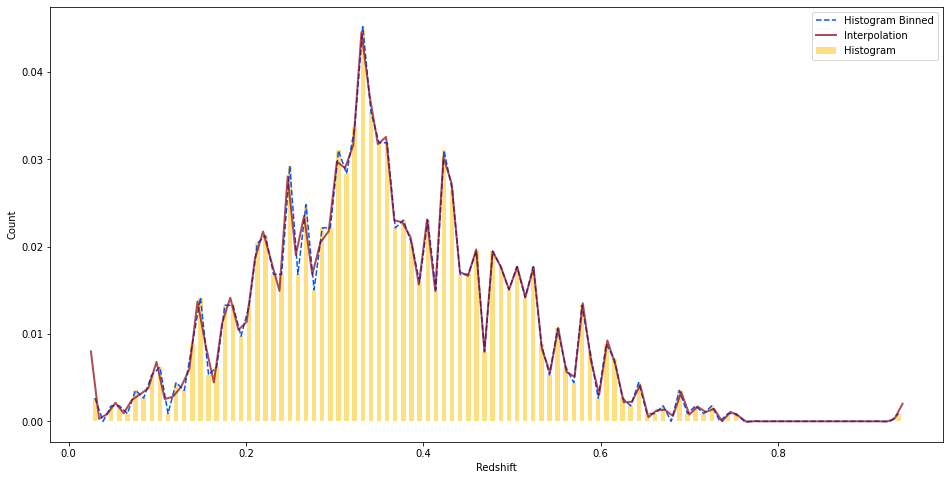

In [10]:
# Plot the histogram, input points and interpolation for comparison

z_values = np.linspace((redshift_min), (redshift_max), num=bin_num)

plt.figure(figsize=[16, 8])
plt.bar(Sne_z_all_bin_centers, Sne_z_all_hist_norm, label="Histogram", alpha=.5, color="#fac205", width=.005)
plt.plot(Sne_z_all_bin_centers, Sne_z_all_hist_norm, label="Histogram Binned", c="#0652ff", ls="--")
plt.plot(z_values, n_sne_interpolated(z_values), label="Interpolation", c="#8c000f", alpha=.7, lw=2)
plt.xlabel("Redshift")
plt.ylabel("Count")
plt.legend()
plt.show()

***

### $\chi(z)$ 

chi_z_func(z_input) - returns tuple with first element value and second element error for integral

### Notes:

- The comoving distance, redshift and derivatives all seem fine when comparing to cosmo-calculator and looking at derivative by eye

In [11]:
# Need to get a list of zBest that is only unique entries:

zBest_unique = []
for i in zBest:
    if i not in zBest_unique:
        zBest_unique.append(i)
        
zBest_unique.sort()

In [12]:
# Define H(z) based on cosmology at start of notebook:

hubble_z_inverse_c = lambda z: c/(np.sqrt((hubble_0**2)*(Omega_m*(1 + z)**3 + Omega_k*(1 + z)**2 + Omega_L)))

In [13]:
# Define chi_z_func - returns tuple with first element value and second element error for integral

chi_z_func = lambda z: scipy.integrate.quad(hubble_z_inverse_c, 0, z)
chi_z_func(.1)

(432.42751124745047, 4.8009097946827335e-12)

In [14]:
# Make a array of \chi(z) for interpolation 

chi_z_unique = []
for z in zBest_unique:
    chi_z_unique.append(chi_z_func(z)[0])

print("Redshift: " + str(zBest_unique[22]) + "      " + "Comoving Distance: " + str(chi_z_unique[22]))

Redshift: 0.101      Comoving Distance: 436.64473205282513


In [15]:
chi_z_func(1)

(3398.5621187715333, 3.773161914879012e-11)

***

### $z(\chi)$ 

z_chi_func(chi_input) - returns redshift for a particular comoving distance

In [16]:
# Interpolate to get z(\chi)

z_chi_func = InterpolatedUnivariateSpline(chi_z_unique, zBest_unique, k=3)
z_chi_func(chi_z_unique[22])

array(0.101)

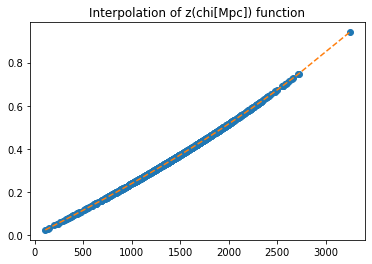

In [17]:
# Plot data and interpolation function for comparison

plt.plot(chi_z_unique, zBest_unique, 'o')
plt.plot(chi_z_unique, z_chi_func(chi_z_unique), '--')
plt.title("Interpolation of z(chi[Mpc]) function")

plt.show()

***

### $dz /\ d\chi$

z_chi_func_deriv(\chi)

In [18]:
z_chi_func_deriv = z_chi_func.derivative()
z_chi_func_deriv(chi_z_unique[22])

array(0.00023718)

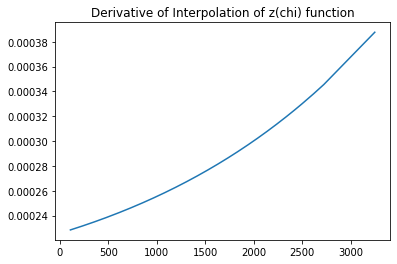

In [19]:
# Plot to check by eye
# Chi plot gives: (.6-.2)/(2500-1000) = .00026 and interpolation graph gives: (1500, .00028). Check. 

plt.plot(chi_z_unique, z_chi_func_deriv(chi_z_unique), '-')
plt.title("Derivative of Interpolation of z(chi) function")

plt.show()

***

### $P(k, z(\chi))$

matter_power_spectrum(k, z)

### Notes: 

- Matter power spectrum look fine when compared to CAMB notebook: https://camb.readthedocs.io/en/latest/CAMBdemo.html

In [20]:
# Need the redshift and kh to have the same number of points 
# so that 2d interpolate gets arrays of the same length later. 

#Now get matter power spectra at redshift 0 and 1.0
params = camb.CAMBparams()
params.set_cosmology(H0=hubble_0, ombh2=ombh2, omch2=omch2)
params.InitPower.set_params(ns=ns)

#Note non-linear corrections couples to smaller scales than you want
params.set_matter_power(redshifts=np.linspace(0.0, 1.0, num = 100), kmax=2.0)

#Linear spectra
params.NonLinear = model.NonLinear_none
results = camb.get_results(params)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 100)

Note: redshifts have been re-sorted (earliest first)


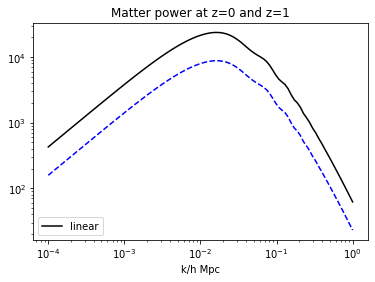

In [21]:
# plor the power spectrum for z=0 and z=1

plt.loglog(kh, pk[0,:], color='k', ls = "-")
plt.loglog(kh, pk[-1,:], color='b', ls = "--")
plt.xlabel('k/h Mpc');
plt.legend(['linear'], loc='lower left');
plt.title('Matter power at z=0 and z=1')
plt.show()

In [22]:
#Interpolate the matter power spectrum into a function with arguments k & z

matter_power_spectrum = interpolate.interp2d(kh, z, pk, kind='quintic')

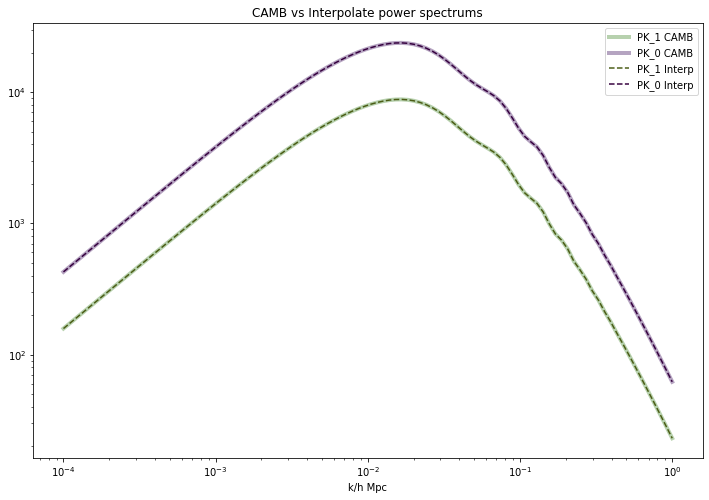

In [23]:
# Plot the matter power spectrum from CAMB and the interpolation
plt.figure(figsize=(12, 8))
kh_list = np.logspace(-4.0, 0, num=100)
z_list = np.linspace(min(z), max(z), num=100)


plt.loglog(kh, pk[-1,:], color='#88b378', ls = "-", label="PK_1 CAMB", linewidth=4, alpha=.6)
plt.loglog(kh, pk[0,:], color='#856798', ls = "-", label="PK_0 CAMB", linewidth=4, alpha=.6)

plt.loglog(kh_list, matter_power_spectrum(kh_list, z_list)[-1,:], color='#4b5d16', ls = "--", label="PK_1 Interp")
plt.loglog(kh_list, matter_power_spectrum(kh_list, z_list)[0,:], color='#36013f', ls = "--", label="PK_0 Interp")

plt.xlabel('k/h Mpc')
#plt.xlim(11**-4, 2)
plt.legend(loc = "upper right")
plt.title("CAMB vs Interpolate power spectrums")
plt.show()

***

$w(\theta)^{gg}_{ur} = b_u b_r \; \int \; n_u(z) n_r(z) \; \frac{dz}{d\chi} \frac{dz}{d\chi} \; d\chi \; \int \frac{k}{2 \pi} \; P(k, z(\chi)) \; J_0(\chi k \theta) \;dk $

### Notes:

- Inputting k_max, and first theta and first chi values integrand_k does evaluate to what it should looking at the power_spectrum graph above. CHECK
- Need to work on good cutoff for bessel, chose the argument cut-off by playing with BesselJ[0,x]*exp(x^2/a) in mathematica - need to do more rigorously

### Questions/Notes (for Ross)

- What should the k range be for integration? In theory 0 to inf but I used the same k range as I use for the power spectrum from CAMB, reasonable?
- Histogram binning for z distribution doesnt seem to affect below results much so not going to worry about that for now
- The integral over k seems OK from some basic checking outlined above, but results seem off by a factor of 100?

In [24]:
def besselJ0(arg):
    return scipy.special.jv(0, arg)


def powerIntegral(x, theta, k_min, k_max):
    
    integrand = lambda k: (k/(2*np.pi)) * ((1.0/h)**3) * matter_power_spectrum(k*h, z_chi_func(x))[0] * besselJ0(k*theta*x)
    integralValue = scipy.integrate.quad(integrand, k_min, k_max, epsrel=10**-12, epsabs=10**-12, limit=5000)
    
    return integralValue[0]



def auto_corr_function_1(bias, theta, k_min, k_max, chi_min, chi_max):
    
    integrand = lambda x: (bias**2) * powerIntegral(x, theta, k_min, k_max) * ((n_sne_interpolated(z_chi_func(x)))**2) * ((z_chi_func_deriv(x))**2)
    CorrValue = scipy.integrate.quad(integrand, chi_min, chi_max, epsrel=10**-12, epsabs=10**-12, limit=5000)
    
    return CorrValue[0]
    


In [25]:
#theta_values = np.logspace(-2, 1, 6)

theta_values = [.1]

corr_func_values = []
for theta in theta_values:
    print(theta)
    value = auto_corr_function_1(bias=1, theta=theta, k_min=.0001*h, k_max=1.0*h, chi_min=chi_z_func(redshift_min)[0], 
                               chi_max=chi_z_func(redshift_max)[0])
    print(value)
    corr_func_values.append(value)


0.1
-1.1018969772481841e-08


In [26]:
def auto_corr_function(bias, theta, k_min, k_max, chi_min, chi_max):
    
    constant = (bias**2) * ((1.0/h)**3)
    
    chi_depend = lambda x: ((n_sne_interpolated(z_chi_func(x)))**2) * ((z_chi_func_deriv(x))**2)
    
    k_depend = lambda k: (k/(2*np.pi))
    
    integrand_full = lambda x, k:  (constant * k_depend(k) 
                                    * chi_depend(x)* matter_power_spectrum(k*h, z_chi_func(x))[0] * scipy.special.jv(0, k*theta*x)) 
    
    value = scipy.integrate.dblquad(integrand_full, k_min, k_max, lambda k: chi_min, lambda k: chi_max)
    
    return value

In [27]:
"""theta_values = np.logspace(-2, 1, 6)

theta_values = [.1]

corr_func_values_1 = []
for theta in theta_values:
    print(theta)
    value = auto_corr_function(bias=1, theta=theta, k_min=.0001*h, k_max=1.0*h, chi_min=chi_z_func(redshift_min)[0], 
                               chi_max=chi_z_func(redshift_max)[0])
    print(value)
    corr_func_values_1.append(value)
"""

'theta_values = np.logspace(-2, 1, 6)\n\ntheta_values = [.1]\n\ncorr_func_values_1 = []\nfor theta in theta_values:\n    print(theta)\n    value = auto_corr_function(bias=1, theta=theta, k_min=.0001*h, k_max=1.0*h, chi_min=chi_z_func(redshift_min)[0], \n                               chi_max=chi_z_func(redshift_max)[0])\n    print(value)\n    corr_func_values_1.append(value)\n'

In [28]:
corr_func_values_single = []
for value in corr_func_values:
    corr_func_values_single.append(value[0])

TypeError: 'float' object is not subscriptable

In [ ]:
plt.figure(figsize=(12, 8))

plt.scatter(theta_values, corr_func_values_single)
#plt.yscale("log")
#plt.xscale("log")
#plt.xlabel("Theta")
#plt.ylabel("w(Theta)")

#plt.title("Theoretical auto correlation function vs theta")

In [ ]:
r_PanSTARRS_Full = np.array(PanSTARRS_Data['r_PanSTARRS_Full'])
xi_PanSTARRS_Full = np.array(PanSTARRS_Data['xi_PanSTARRS_Full'])

In [ ]:
plt.figure(figsize=(12, 8))

plt.plot(r_PanSTARRS_Full, xi_PanSTARRS_Full, color='#4b5d16', label="Data")
plt.plot(r_PanSTARRS_Full, -xi_PanSTARRS_Full, color='#4b5d16', ls=':')

plt.scatter(theta_values, corr_func_values_single, color='#36013f', ls="--", label="Theory")

plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'w($\theta$)')
plt.legend(loc='upper right')
#plt.xlim([0.01,10])

plt.show()

In [ ]:
"""t5 = datetime.now()

theta_values = np.logspace(-2, 1, 8)

# Parallelizing using Pool.apply()

# Step 1: Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

# Step 2: `pool.apply` the `howmany_within_range()`
corr_func_values = [pool.apply(auto_corr_function, args=(1, theta, .01, 1, chi_z_func(redshift_min)[0], 
                                                         chi_z_func(redshift_max)[0])) for theta in theta_values]

# Step 3: Don't forget to close
pool.close()    

print(corr_func_values)

t6 = datetime.now()"""
print()

In [ ]:
"""theta_values = np.logspace(-2, 1, 100)

chi_min_data = chi_z_func(redshift_min)[0]
chi_max_data = chi_z_func(redshift_max)[0]
chi_values = np.linspace(chi_min_data, chi_max_data, 100)

#Taken from the power spectrum range:
k_min = .0001 * h
k_max = 1.0 * h

arg_cut = 10000.0

corr_func_values = []
for theta in theta_values:
    
    integral_k_chi_values = []
    for chi in chi_values:
        
        bessel_arg = lambda k: k*theta*z_chi_func(chi)
        bessel_0 = lambda k: scipy.special.jv(0, bessel_arg(k)) 
        integrad_k = lambda k: (k/(2*np.pi))*matter_power_spectrum(k/h, z_chi_func(chi))[0]*bessel_0(k)*np.exp((bessel_arg(k)**2)/(arg_cut**2))
        #integrad_k = lambda k: (k/(2*np.pi))*matter_power_spectrum(k/h, z_chi_func(chi))[0]
        
        integral_k_chi = scipy.integrate.quad(integrad_k, k_min, k_max)[0]
        integral_k_chi_values.append(integral_k_chi)

    power_integral_chi_func = interpolate.interp1d(integral_k_chi_values, chi_values, kind='cubic', fill_value="extrapolate")
    #print(power_integral_chi_func(theta))
    print(len(corr_func_values)/len(theta_values))

    
    integrand_chi = lambda x: ((n_sne_interpolated(z_chi_func(x)))**2) * ((z_chi_func_deriv(x))**2) * power_integral_chi_func(theta) * (bias_Sne**2)
    integral_chi = scipy.integrate.quad(integrand_chi, 0, chi_max_data)[0]
    
    #print(integral_chi)
    corr_func_values.append(integral_chi)
    
    #print(len(corr_func_values)/len(theta_values))
          
Correlation = power_integral_chi_func = interpolate.interp1d(corr_func_values, theta_values, kind='cubic', fill_value="extrapolate")"""
print()


In [ ]:
"""def BesselJ0(k):
    bessel_J0 = lambda x: scipy.special.jv(0, k*theta*x)
    return bessel_J0
      
    
#Camb power spec in units Mpc^3/h need it independent of h 
def integral_PowerSpectrum_overK(k_min, k_max):
    
    integrad_k = lambda k, x: k/(2*np.pi) * h * matter_power_spectrum(k/h, z_chi_func(x))[0] * BesselJ0(k)
    integral_k = lambda x: scipy.integrate.quad(integrad_k(x), k_min, k_max, epsrel=10**-12, epsabs=10**-12, limit=5000)
    
    return integral_k[0]
    
    
def auto_corr_function(bias, theta, k_min, k_max, chi_min, chi_max):
    
    integrand_chi = lambda x: (bias**2) * ((n_sne_interpolated(z_chi_func(x)))**2) * ((z_chi_func_deriv(x))**2) * integral_PowerSpectrum_overK(k_min, k_max)(x)
    integral_chi = scipy.integrate.quad(integrand_chi, chi_min, chi_max)
    
    return integral_chi[0] """
print()

In [ ]:
"""# BesselJ0(theta) returns a function dependent on k, x: BesselJ0(theta)(k, x)
def BesselJ0(theta):
    bessel_J0 = lambda k, x: scipy.special.jv(0, k*theta*x)
    return bessel_J0 

# integral_PowerSpectrum_overK(k_min, k_max) returns a function dependent on x only: integral_PowerSpectrum_overK(k_min, k_max)(x)
def integral_PowerSpectrum_overK(k_min, k_max):
    
    integrad_k = lambda k, x: k/(2*np.pi) * h * matter_power_spectrum(k/h, z_chi_func(x))[0] * BesselJ0(theta)(k, x)
    integral_k = lambda x: scipy.integrate.quad(integrad_k, k_min, k_max, epsrel=10**-12, epsabs=10**-12, limit=5000)
    
    return integral_k

integral_PowerSpectrum_overK(.1, 1)(1)"""
print()